# Data Augmentation using Imgaug library -  only for images

This notebook will produce a new collection of training images that are augmented from the original training set. Bands 1 and 2 are transformed independently. All augmented images will be saved in an output json file. The saved format will be same as the original data files, eg. 

`pandas.DataFrame(['band_1', 'band_2', 'is_iceberg'])`

Many of the ideas created in the new augmented training set was inspired by examples in this github repo: (https://github.com/aleju/imgaug).


Why apply data augmentation?

The original training set consists of a relatively small set of training examples, about ~600-700 images per class.
Since we only have several hundred examples per class, we should be concerned with overfitting. Data augmentation is one way to fight overfitting, but keep in mind that augmented images are still highly correlated.

In [1]:
%matplotlib inline
import cv2
import imgaug
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from imgaug import augmenters as ima

# Local imports
import adjust_path  # Before doing any local imports
from icc.data_loader import DataLoader
from icc.contrib.preprocessing.utils import *

Appending "/code/notebooks/.." to path


In [2]:
# Load training data here
X, y = DataLoader.load_train()

In [4]:
def plt_imgs(im, labels):
    '''Helper function to plot 10 images at a time.
    Example: plt_imgs(imgs, y_train[:10])
    
    Args:
        im: list or array of images, if single image then store in a list.
        labels: list or array of labels, if single label then store in a list.
        
    '''
    ids = ['ship', 'iceberg']
    for i in range(len(im)):
        print('{}: {}'.format(i, ids[labels[i]]))
        plt.imshow(np.squeeze(im[i]))
        plt.pause(1)


def reformat_bands(X):
    """Helper func to reformat bands into 75x75X1 images"""
    band_1 = np.asarray(X['band_1'].tolist()).reshape(-1,75,75)
    band_1 = band_1[:,:,:,np.newaxis]
    band_2 = np.asarray(X['band_2'].tolist()).reshape(-1,75,75)
    band_2 = band_2[:,:,:,np.newaxis]
    return [band_1, band_2]

In [17]:
# Data augmentation functions.
def emboss_and_shear(imgs):
    seq = ima.Sequential([ima.Emboss(alpha=1, strength=2.0), ima.Affine(scale=1.0, shear=45)])
    if len(imgs.shape) == 3: imgs = [imgs]
    return seq.augment_images(imgs)


def affine_and_translate(imgs):
    seq = ima.Sequential([ima.Affine(scale=1.0, translate_percent=0.2)])
    if len(imgs.shape) == 3: imgs = [imgs]
    return seq.augment_images(imgs)


def constrast_norm(imgs):
    seq = ima.Sequential([ima.ContrastNormalization((0.4, 0.6))])
    if len(imgs.shape) == 3: imgs = [imgs]
    return seq.augment_images(imgs)


def crop_and_resize(imgs):
    if len(imgs.shape) == 3:
        cropped = [np.squeeze(imgs)[10:10+50, 10:10+50]]
        m = 1
    else:
        cropped = np.squeeze(imgs)[:, 10:10+50, 10:10+50]
        m = cropped.shape[0]

    h, w = 75, 75
    resized = np.zeros((m, h, w))
    for i, img in enumerate(cropped):
        resized[i,:,:] = cv2.resize(img, (h, w), interpolation= cv2.INTER_AREA)
    return resized[:,:,:,np.newaxis]


def flipLR_and_rotate(imgs):
    seq = ima.Sequential([ima.Fliplr((0.6)), ima.Affine(scale=1.0, rotate=90)])
    if len(imgs.shape) == 3: imgs = [imgs]
    return seq.augment_images(imgs)


def stacked_augmentation():
    band_1, band_2 = get_bands(X)
    
    b1_augmented = np.concatenate([band_1, 
                                   emboss_and_shear(band_1), 
                                   affine_and_translate(band_1),
                                   crop_and_resize(band_1),
                                   flipLR_and_rotate(band_1),
                                   constrast_norm(band_1)])

    b2_augmented = np.concatenate([band_2, 
                                   emboss_and_shear(band_2), 
                                   affine_and_translate(band_2),
                                   crop_and_resize(band_2),
                                   flipLR_and_rotate(band_2),
                                   constrast_norm(band_2)])
    
    return pd.DataFrame({'band_1': np.squeeze(b1_augmented).reshape(-1,75*75).tolist(), 
                         'band_2': np.squeeze(b2_augmented).reshape(-1,75*75).tolist()})

In [6]:
band1, band2 = reformat_bands(X)
example_id = 0
label = [y[example_id]]

0: ship


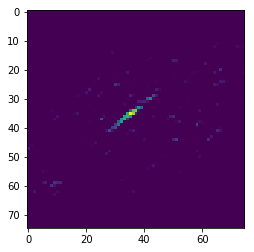

In [9]:
img = emboss_and_shear(band1[example_id])
plt_imgs(img, label)

0: ship


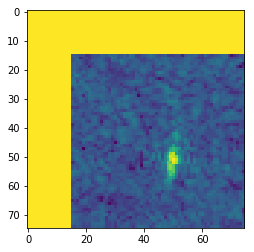

In [10]:
img = affine_and_translate(band1[example_id])
plt_imgs(img, label)

0: ship


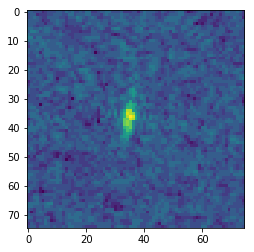

In [11]:
img = constrast_norm(band1[example_id])
plt_imgs(img, label)

0: ship


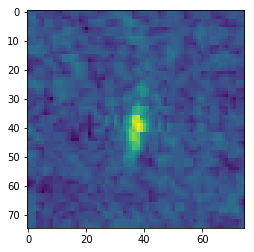

In [18]:
img = crop_and_resize(band1[example_id])
plt_imgs(img, label)

0: ship


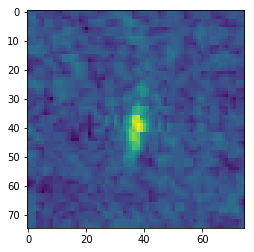

1: ship


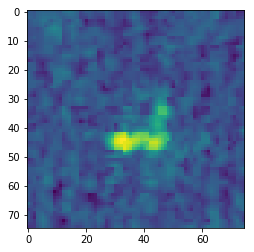

2: iceberg


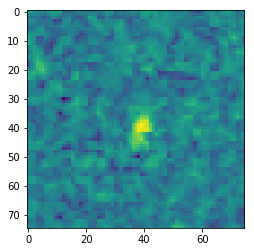

In [19]:
img = crop_and_resize(band1[:3])
plt_imgs(img, y[:3])

0: ship


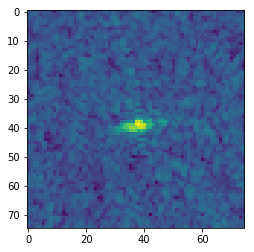

In [20]:
img = flipLR_and_rotate(band1[example_id])
plt_imgs(img, label)

Only run if you want to stack all types of augmentations into one dataset. It does not perform all augmentations per image. Imgaug will have examples showing how to perform several transformations on one image.

In [ ]:
data = stacked_augmentation()

# Process data into original training file format.
data['band_1'] = data['band_1'].map(np.array)
data['band_2'] = data['band_2'].map(np.array)
data['is_iceberg'] = np.tile(y, 6)

# Save new data
if False:
    data.to_json('../data/augmented_trainset.json')